In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import itertools
import geopandas as gpd
import os

In [2]:
#Dir path
#Case='NorthDakota'
Case='Colorado'
#Case='Idaho'

start_y=2008
end_y=2023

sites_pth = 'Data/'+Case+'/sites/'
cdl_pth = 'Data/'+Case+'/cdl/'
season_pth = 'Data/'+Case+'/season/'

site_names = os.listdir(sites_pth)
cdl_names = os.listdir(cdl_pth)
season_names = os.listdir(season_pth)
location=np.load('Data/'+Case+'/masklayers/wgscenterlist.npy')
num_sites=len(site_names)

timelog=pd.read_hdf('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Event_log/log_'+Case+'_240524_max09_df.h5')

In [32]:
#get all cases detected
print(Case+' cases')
all_cases_detected=np.unique(timelog['CaseID'])

#identiy not detected cases
not_detected_cases=[]
for i in range(num_sites):
    for yt in np.arange(start_y,end_y):
        if f'{i:04}_{yt}' not in all_cases_detected:
            not_detected_cases.append(f'{i:04}_{yt}')
if Case=='Colorado':#remove invalid polygon in colorado case mask
    not_detected_cases = [case for case in not_detected_cases if not (case[:4] == "0113" or case[:4] == "0158")]

#identify the crop corresponding to the not detected cases
crop_id=[ 'Unidentify','Corn','Cotton','Rice','Sorghum','Soybeans','Sunflower','','','','Peanuts','Tobacco','Sweet Corn','Pop or Orn Corn','Mint','','','','','','','Barley','Durum Wheat','Spring Wheat','Winter Wheat','Other Small Grains','Dbl Crop WinWht/Soybeans','Rye','Oats','Millet','Speltz','Canola','Flaxseed','Safflower','Rape Seed','Mustard','Alfalfa','Other Hay/Non Alfalfa','Camelina','Buckwheat','','Sugarbeets','Dry Beans','Potatoes','Other Crops','Sugarcane','Sweet Potatoes','Misc Vegs & Fruits','Watermelons','Onions','Cucumbers','Chick Peas','Lentils','Peas','Tomatoes','Caneberries','Hops','Herbs','Clover/Wildflowers','Sod/Grass Seed','Switchgrass','Fallow/Idle Cropland','Pasture/Grass','Forest','Shrubland','Barren','Cherries','Peaches','Apples','Grapes','Christmas Trees','Other Tree Crops','Citrus','Pecans','Almonds','Walnuts','Pears','','','','Clouds/No Data','Developed','Water','','','','Wetlands','Nonag/Undefined','','','','Aquaculture','','','','','','','','','','','','','','','','','','','Open Water','Perennial Ice/Snow','','','','','','','','','Developed/Open Space','Developed/Low Intensity','Developed/Med Intensity','Developed/High Intensity','','','','','','','Barren','','','','','','','','','','Deciduous Forest','Evergreen Forest','Mixed Forest','','','','','','','','','Shrubland','','','','','','','','','','','','','','','','','','','','','','','','Grassland/Pasture','','','','','','','','','','','','','','Woody Wetlands','','','','','Herbaceous Wetlands','','','','','','','','','Pistachios','Triticale','Carrots','Asparagus','Garlic','Cantaloupes','Prunes','Olives','Oranges','Honeydew Melons','Broccoli','Avocados','Peppers','Pomegranates','Nectarines','Greens','Plums','Strawberries','Squash','Apricots','Vetch','Dbl Crop WinWht/Corn','Dbl Crop Oats/Corn','Lettuce','Dbl Crop Triticale/Corn','Pumpkins','Dbl Crop Lettuce/Durum Wht','Dbl Crop Lettuce/Cantaloupe','Dbl Crop Lettuce/Cotton','Dbl Crop Lettuce/Barley','Dbl Crop Durum Wht/Sorghum','Dbl Crop Barley/Sorghum','Dbl Crop WinWht/Sorghum','Dbl Crop Barley/Corn','Dbl Crop WinWht/Cotton','Dbl Crop Soybeans/Cotton','Dbl Crop Soybeans/Oats','Dbl Crop Corn/Soybeans','Blueberries','Cabbage','Cauliflower','Celery','Radishes','Turnips','Eggplants','Gourds','Cranberries','','','','Dbl Crop Barley/Soybeans']
CropID=[]
for i in not_detected_cases:
    sid=int(i[:4])
    cdl=pd.read_hdf(cdl_pth+f'/Site{sid:03}_cdl.h5')
    cid=cdl.loc[int(i[-4:])]
    CropID.append(crop_id[int(cid)])

print('For all ',num_sites*(end_y-start_y),' possible cases ',len(not_detected_cases), ' cases were not detected')

def warn_mark(i,n):
    return f"{i:04}_{n+start_y}"
def warn_site_years(Lst):
    threshold=np.nonzero(np.array(Lst[1])<0.75)[0]
    return list(map(lambda x: warn_mark(Lst[0], x), threshold))

with open(cdl_pth+"/ConsistencyPerc", "rb") as fp:   # Unpickling
    site_consistencyL = pickle.load(fp)

CaseID_anom=list(map(warn_site_years, enumerate(site_consistencyL)))

flat_CaseID_anom = list(itertools.chain.from_iterable(CaseID_anom))
invalid_due_to_multicrop=[case in flat_CaseID_anom for case in not_detected_cases]
print(sum(invalid_due_to_multicrop), ' undetected cases were multi crop cases')
not_detected_cases_exclude_multicrop=[not_detected_cases[i] for i in range(len(not_detected_cases)) if not invalid_due_to_multicrop[i]]
CropID_exclude_multicrop=[CropID[i] for i in range(len(not_detected_cases)) if not invalid_due_to_multicrop[i]]
print('After excluding multi crop cases, ',len(not_detected_cases_exclude_multicrop),' cases remains undetected')

Colorado cases
For all  2400  possible cases  30  cases were not detected
4  undetected cases were multi crop cases
After excluding multi crop cases,  26  cases remains undetected


In [120]:
df = pd.DataFrame({'not_detected_cases': not_detected_cases})

# Extract the first 4 characters into a new column
df['site'] = df['not_detected_cases'].str[:4]

# Extract the last 4 characters into a new column
df['year'] = df['not_detected_cases'].str[-4:]
df['CropID']=CropID
df.drop('not_detected_cases', axis=1, inplace=True)

df_ex_multi = pd.DataFrame({'not_detected_cases': not_detected_cases_exclude_multicrop})

# Extract the first 4 characters into a new column
df_ex_multi['site'] = df_ex_multi['not_detected_cases'].str[:4]

# Extract the last 4 characters into a new column
df_ex_multi['year'] = df_ex_multi['not_detected_cases'].str[-4:]
df_ex_multi['CropID']=CropID_exclude_multicrop
df_ex_multi.drop('not_detected_cases', axis=1, inplace=True)

C:\Users\Vito\AppData\Local\Temp\ipykernel_6568\2855248965.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0,2].set_xticklabels(crops, rotation=45)
C:\Users\Vito\AppData\Local\Temp\ipykernel_6568\2855248965.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1,2].set_xticklabels(crops, rotation=45)


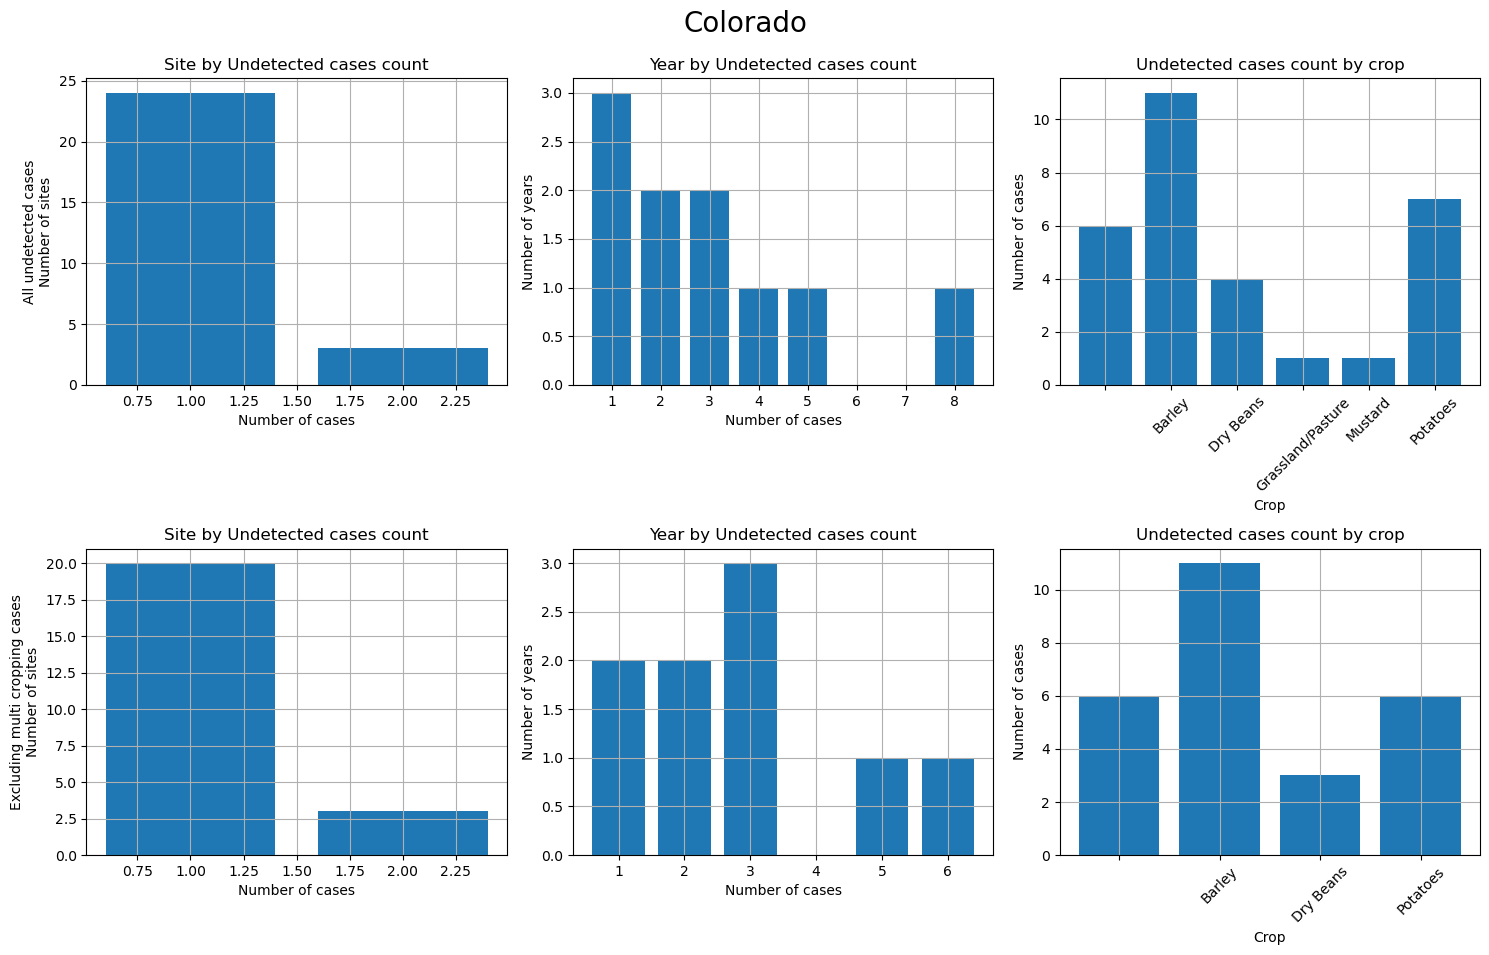

In [53]:
sites,site_undetected_count=np.unique(df['site'], return_counts=True) 
years,year_undetected_count=np.unique(df['year'], return_counts=True)
crops,crop_undetected_count=np.unique(df['CropID'], return_counts=True) 

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0,0].bar(np.unique(site_undetected_count, return_counts=True)[0],np.unique(site_undetected_count, return_counts=True)[1])
ax[0,0].set_title('Site by Undetected cases count')
ax[0,0].set_ylabel('All undetected cases\nNumber of sites')
ax[0,0].set_xlabel('Number of cases')
ax[0,0].grid()


ax[0,1].bar(np.unique(year_undetected_count, return_counts=True)[0],np.unique(year_undetected_count, return_counts=True)[1])
ax[0,1].set_title('Year by Undetected cases count')
ax[0,1].set_ylabel('Number of years')
ax[0,1].set_xlabel('Number of cases')
ax[0,1].grid()

ax[0,2].bar(crops,crop_undetected_count)
ax[0,2].set_title('Undetected cases count by crop')
ax[0,2].set_xlabel('Crop')
ax[0,2].set_ylabel('Number of cases')
ax[0,2].set_xticklabels(crops, rotation=45)
ax[0,2].grid()

sites,site_undetected_count=np.unique(df_ex_multi['site'], return_counts=True) 
years,year_undetected_count=np.unique(df_ex_multi['year'], return_counts=True)
crops,crop_undetected_count=np.unique(df_ex_multi['CropID'], return_counts=True) 

ax[1,0].bar(np.unique(site_undetected_count, return_counts=True)[0],np.unique(site_undetected_count, return_counts=True)[1])
ax[1,0].set_title('Site by Undetected cases count')
ax[1,0].set_ylabel('Excluding multi cropping cases\nNumber of sites')
ax[1,0].set_xlabel('Number of cases')
ax[1,0].grid()


ax[1,1].bar(np.unique(year_undetected_count, return_counts=True)[0],np.unique(year_undetected_count, return_counts=True)[1])
ax[1,1].set_title('Year by Undetected cases count')
ax[1,1].set_ylabel('Number of years')
ax[1,1].set_xlabel('Number of cases')
ax[1,1].grid()

ax[1,2].bar(crops,crop_undetected_count)
ax[1,2].set_title('Undetected cases count by crop')
ax[1,2].set_xlabel('Crop')
ax[1,2].set_ylabel('Number of cases')

ax[1,2].set_xticklabels(crops, rotation=45)
ax[1,2].grid()
plt.suptitle(Case,fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Result/undetected'+Case+'.pdf')
plt.show()

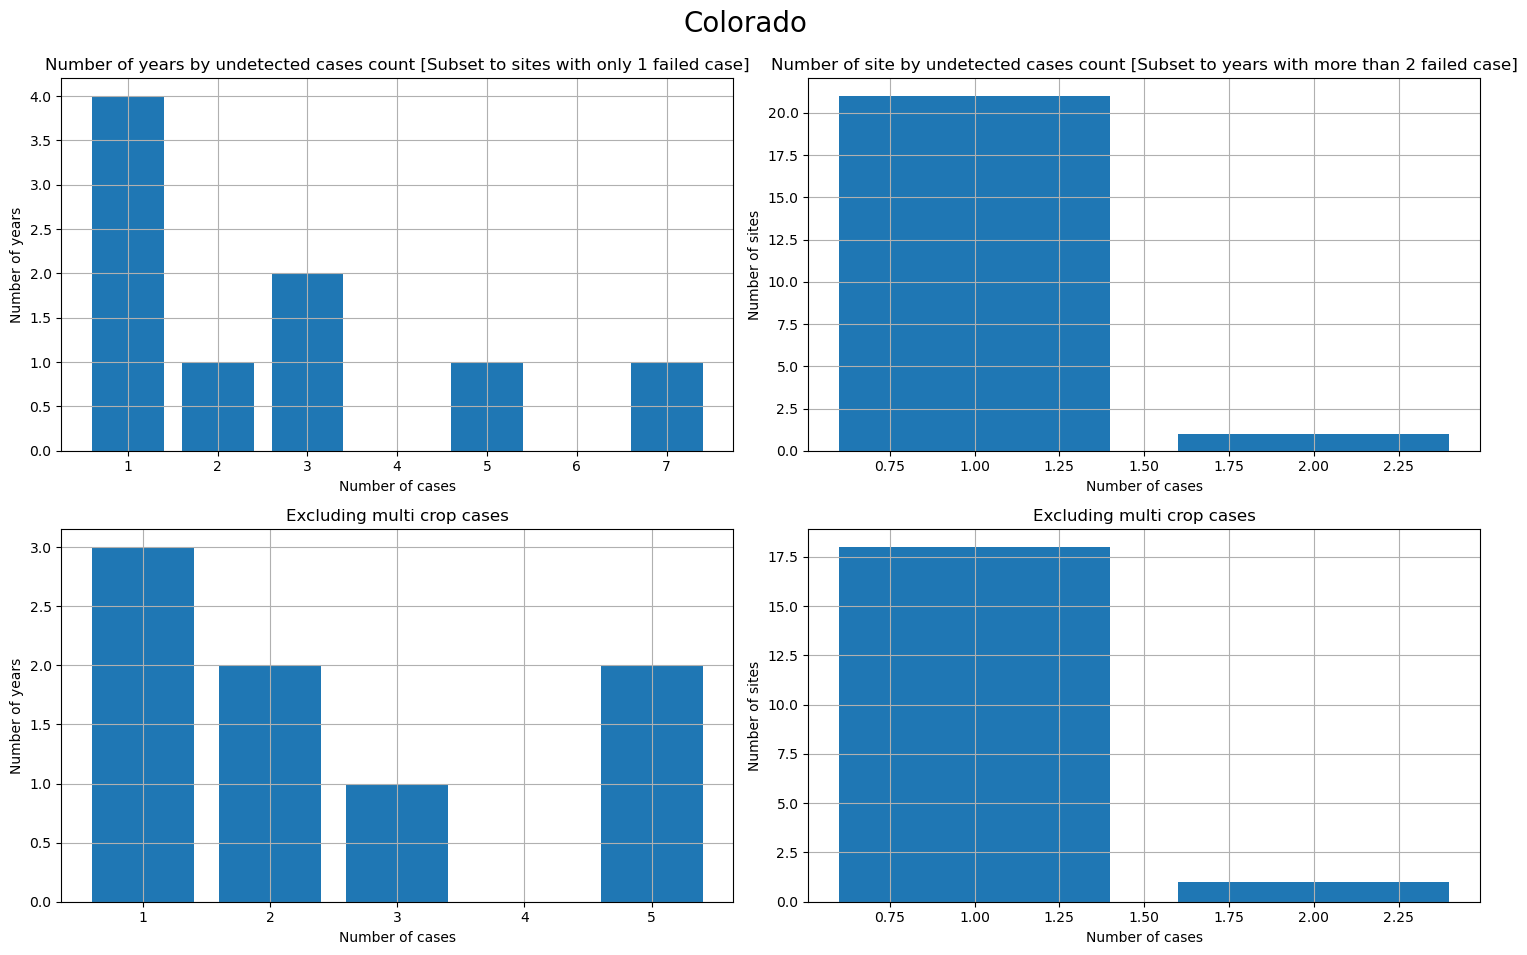

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sites,site_failed_count=np.unique(df['site'], return_counts=True) 
years,year_failed_count=np.unique(df['year'], return_counts=True) 
subset_df = df[df['site'].isin(sites[site_failed_count==1])]
subset_df.reset_index(drop=True, inplace=True)
years,year_failed_count=np.unique(subset_df['year'], return_counts=True) 

ax[0,0].bar(np.unique(year_failed_count, return_counts=True)[0],np.unique(year_failed_count, return_counts=True)[1])
ax[0,0].set_title('Number of years by undetected cases count [Subset to sites with only 1 failed case]')
ax[0,0].set_ylabel('Number of years')
ax[0,0].set_xlabel('Number of cases')
ax[0,0].grid()

sites,site_failed_count=np.unique(df['site'], return_counts=True) 
years,year_failed_count=np.unique(df['year'], return_counts=True) 
subset_df = df[df['year'].isin(years[year_failed_count>2])]
subset_df.reset_index(drop=True, inplace=True)
site,site_failed_count=np.unique(subset_df['site'], return_counts=True) 

ax[0,1].bar(np.unique(site_failed_count, return_counts=True)[0],np.unique(site_failed_count, return_counts=True)[1])
ax[0,1].set_title('Number of site by undetected cases count [Subset to years with more than 2 failed case]')
ax[0,1].set_ylabel('Number of sites')
ax[0,1].set_xlabel('Number of cases')
ax[0,1].grid()

sites,site_failed_count=np.unique(df_ex_multi['site'], return_counts=True) 
years,year_failed_count=np.unique(df_ex_multi['year'], return_counts=True) 
subset_df = df_ex_multi[df_ex_multi['site'].isin(sites[site_failed_count==1])]
subset_df.reset_index(drop=True, inplace=True)
years,year_failed_count=np.unique(subset_df['year'], return_counts=True) 

ax[1,0].bar(np.unique(year_failed_count, return_counts=True)[0],np.unique(year_failed_count, return_counts=True)[1])
ax[1,0].set_title('Excluding multi crop cases')
ax[1,0].set_ylabel('Number of years')
ax[1,0].set_xlabel('Number of cases')
ax[1,0].grid()

sites,site_failed_count=np.unique(df_ex_multi['site'], return_counts=True) 
years,year_failed_count=np.unique(df_ex_multi['year'], return_counts=True) 
subset_df = df_ex_multi[df_ex_multi['year'].isin(years[year_failed_count>2])]
subset_df.reset_index(drop=True, inplace=True)
site,site_failed_count=np.unique(subset_df['site'], return_counts=True) 

ax[1,1].bar(np.unique(site_failed_count, return_counts=True)[0],np.unique(site_failed_count, return_counts=True)[1])
ax[1,1].set_title('Excluding multi crop cases')
ax[1,1].set_ylabel('Number of sites')
ax[1,1].set_xlabel('Number of cases')
ax[1,1].grid()

plt.suptitle(Case,fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Result/undetected_subset'+Case+'.pdf')
plt.show()

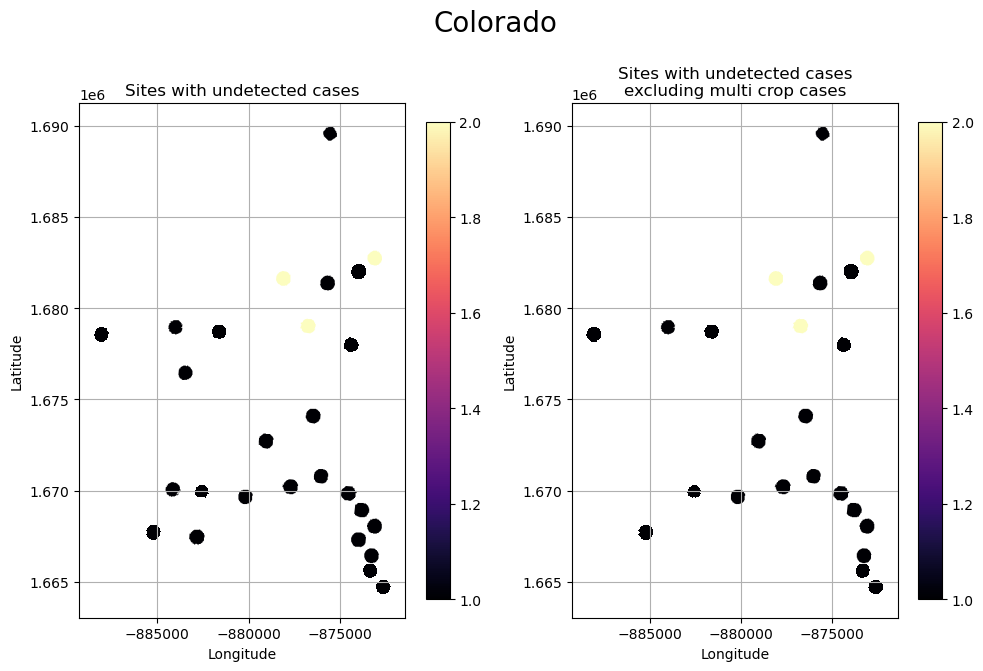

In [37]:
#plotting where it fails
shapefile_path = 'Data/'+Case+'/masklayers/site_mask.shp'
#= 'C:/Users/Vito/Documents/p1/masklayers/potato_flt_mask.shp'
gdf = gpd.read_file(shapefile_path)

int_sites=[int(i) for i in np.unique(df['site'])]
sites,site_failed_count=np.unique(df['site'], return_counts=True)

subset_gdf = gdf.loc[int_sites]
#subset_gdf = gdf.iloc[158]
subset_gdf.reset_index(drop=True, inplace=True)
subset_gdf['count']=site_failed_count

fig, ax = plt.subplots(1, 2, figsize=(10, 7))

im1=subset_gdf.plot(ax=ax[0],column=subset_gdf['count'],cmap='magma', legend=True, legend_kwds={'shrink': 0.8})

ax[0].set_title('Sites with undetected cases')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')
ax[0].grid()

#without multi crop
int_sites=[int(i) for i in np.unique(df_ex_multi['site'])]
sites,site_failed_count=np.unique(df_ex_multi['site'], return_counts=True)

subset_gdf = gdf.loc[int_sites]
#subset_gdf = gdf.iloc[158]
subset_gdf.reset_index(drop=True, inplace=True)
subset_gdf['count']=site_failed_count

im1=subset_gdf.plot(ax=ax[1],column=subset_gdf['count'],cmap='magma', legend=True, legend_kwds={'shrink': 0.8})


ax[1].set_title('Sites with undetected cases\nexcluding multi crop cases')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
ax[1].grid()

plt.suptitle(Case,fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.995])
plt.savefig('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Result/undetected_location'+Case+'.pdf')
plt.show()

In [142]:
def LMM_count(ts):
    local_maxima_indices = np.where((ts[:-2] < ts[1:-1]) & (ts[1:-1] > ts[2:]))[0] + 1
    local_minima_indices = np.where((ts[:-2] > ts[1:-1]) & (ts[1:-1] < ts[2:]))[0] + 1
    return len(local_maxima_indices)+len(local_minima_indices)

In [143]:
valid_ssL_ALL=[]
valid_esL_ALL=[]
valid_nan_ALL=[]
valid_LMM_ALL=[]
for caseid in timelog['CaseID'].unique():
    sid=int(caseid[:4])
    yt=caseid[-4:]
    ts=pd.read_hdf(sites_pth+f'/Site{sid:03}_NBARint.h5')
    ts.drop('std', axis=1, inplace=True)
    ts=ts.loc[yt]
    LMM=LMM_count(ts['mean'].values)
    valid_LMM_ALL.append(LMM)
    nancount=ts['mean'].isna().sum()
    valid_nan_ALL.append(nancount)
    season=pd.read_hdf(season_pth+f'/Site{sid:03}_season_day.h5')
    valid_ssL_ALL.append(season.loc[int(yt)]['start_season'].dayofyear)
    valid_esL_ALL.append(season.loc[int(yt)]['end_season'].dayofyear)

invalid_nan_ALL=[]
invalid_ssL_ALL=[]
invalid_esL_ALL=[]
invalid_LMM_ALL=[]
for index, row in df.iterrows():
    sid=int(row['site'])
    yt=row['year']
    ts=pd.read_hdf(sites_pth+f'/Site{sid:03}_NBARint.h5')
    ts.drop('std', axis=1, inplace=True)
    ts=ts.loc[yt]
    LMM=LMM_count(ts['mean'].values)
    invalid_LMM_ALL.append(LMM)
    nancount=ts['mean'].isna().sum()
    invalid_nan_ALL.append(nancount)
    season=pd.read_hdf(season_pth+f'/Site{sid:03}_season_day.h5')
    invalid_ssL_ALL.append(season.loc[int(yt)]['start_season'].dayofyear)
    invalid_esL_ALL.append(season.loc[int(yt)]['end_season'].dayofyear)

invalid_nan_ALL_ex_multi=[]
invalid_ssL_ALL_ex_multi=[]
invalid_esL_ALL_ex_multi=[]
invalid_LMM_ALL_ex_multi=[]
for index, row in df_ex_multi.iterrows():
    sid=int(row['site'])
    yt=row['year']
    ts=pd.read_hdf(sites_pth+f'/Site{sid:03}_NBARint.h5')
    ts.drop('std', axis=1, inplace=True)
    ts=ts.loc[yt]
    LMM=LMM_count(ts['mean'].values)
    invalid_LMM_ALL_ex_multi.append(LMM)
    nancount=ts['mean'].isna().sum()
    invalid_nan_ALL_ex_multi.append(nancount)
    season=pd.read_hdf(season_pth+f'/Site{sid:03}_season_day.h5')
    invalid_ssL_ALL_ex_multi.append(season.loc[int(yt)]['start_season'].dayofyear)
    invalid_esL_ALL_ex_multi.append(season.loc[int(yt)]['end_season'].dayofyear)

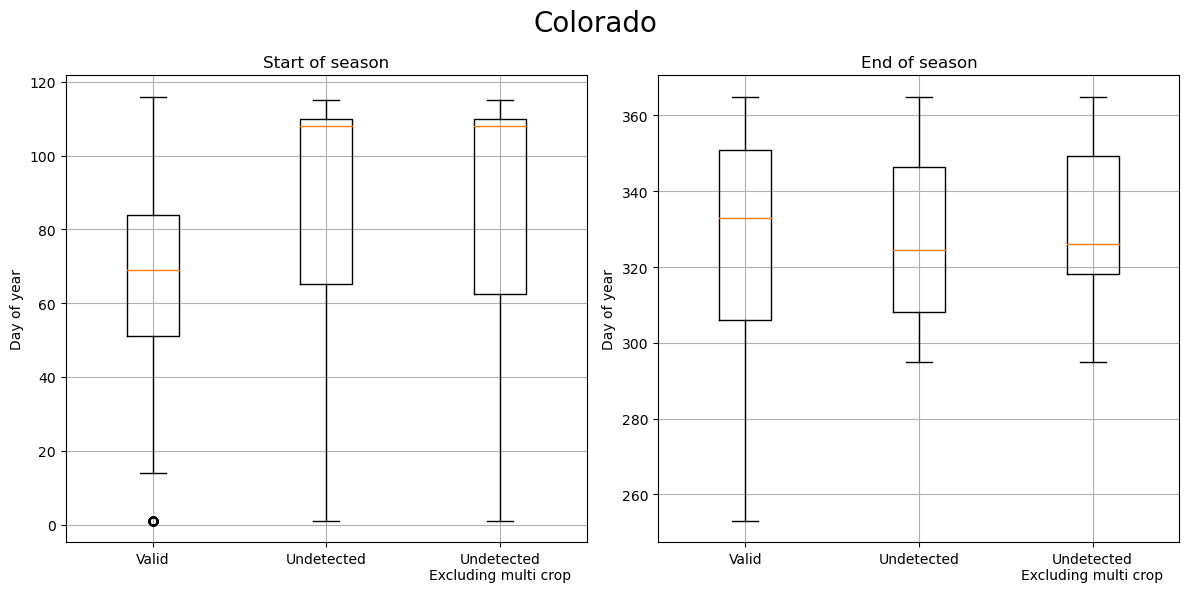

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].boxplot([valid_ssL_ALL,invalid_ssL_ALL, invalid_ssL_ALL_ex_multi])
ax[0].set_title('Start of season')
ax[0].set_ylabel('Day of year')
ax[0].set_xticklabels(['Valid','Undetected','Undetected\nExcluding multi crop'])
ax[0].grid()

ax[1].boxplot([valid_esL_ALL,invalid_esL_ALL, invalid_esL_ALL_ex_multi])
ax[1].set_title('End of season')
ax[1].set_ylabel('Day of year')
ax[1].set_xticklabels(['Valid','Undetected','Undetected\nExcluding multi crop'])
ax[1].grid()

plt.suptitle(Case,fontsize=20)
plt.tight_layout()
plt.savefig('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Result/boxplot_season'+Case+'ALL.pdf')
plt.show()

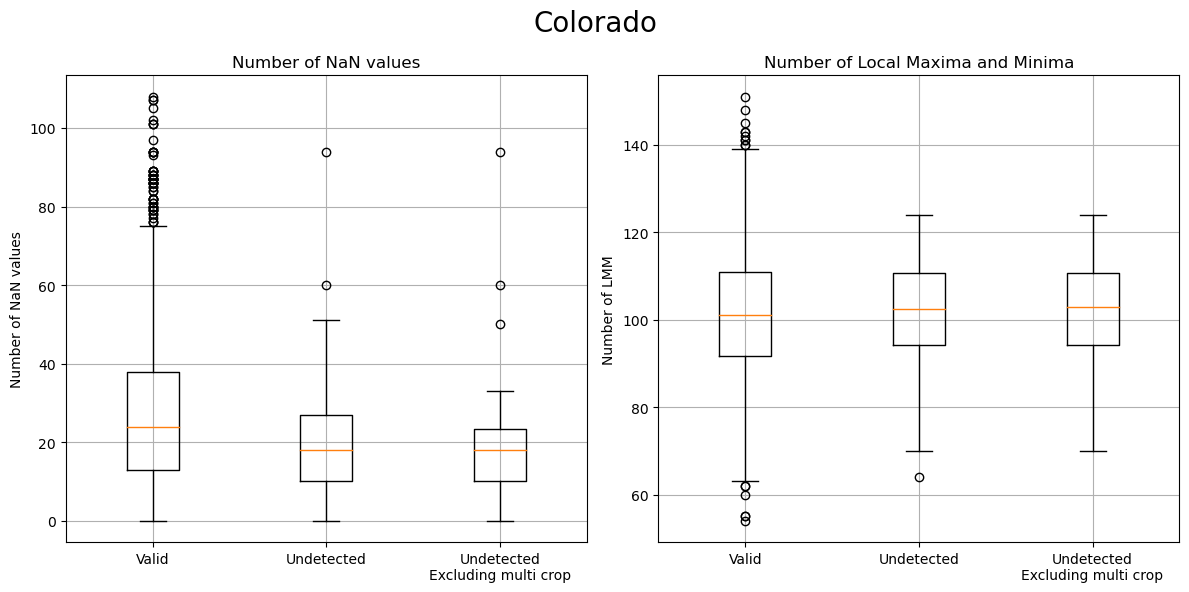

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].boxplot([valid_nan_ALL,invalid_nan_ALL, invalid_nan_ALL_ex_multi])
ax[0].set_title('Number of NaN values')
ax[0].set_ylabel('Number of NaN values')
ax[0].set_xticklabels(['Valid','Undetected','Undetected\nExcluding multi crop'])
ax[0].grid()

ax[1].boxplot([valid_LMM_ALL,invalid_LMM_ALL, invalid_LMM_ALL_ex_multi])
ax[1].set_title('Number of Local Maxima and Minima')
ax[1].set_ylabel('Number of LMM')
ax[1].set_xticklabels(['Valid','Undetected','Undetected\nExcluding multi crop'])
ax[1].grid()

plt.suptitle(Case,fontsize=20)
plt.tight_layout()
plt.savefig('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Result/boxplot_nanLMM'+Case+'ALL.pdf')
plt.show()

In [126]:
#crop='Potatoes'
crop='Barley'
valid_tsList=[]
valid_ssL=[]
valid_esL=[]
for caseid in timelog[timelog['Crop']==crop]['CaseID'].unique():
    sid=int(caseid[:4])
    yt=caseid[-4:]
    ts=pd.read_hdf(sites_pth+f'/Site{sid:03}_NBARint.h5')
    ts.drop('std', axis=1, inplace=True)
    ts['DayOfYear'] = ts.index.dayofyear
    valid_tsList.append(ts.loc[yt])
    season=pd.read_hdf(season_pth+f'/Site{sid:03}_season_day.h5')
    valid_ssL.append(season.loc[int(yt)]['start_season'].dayofyear)
    valid_esL.append(season.loc[int(yt)]['end_season'].dayofyear)
valid_ts_df = pd.concat(valid_tsList, axis=0)
valid_ts_df_doy=valid_ts_df.groupby('DayOfYear')

In [127]:
crop_df=df_ex_multi[df_ex_multi['CropID']==crop]#.iloc[0]
crop_df.reset_index(drop=True, inplace=True)
invalid_tsList=[]
invalid_ssL=[]
invalid_esL=[]
for index, row in crop_df.iterrows():
    sid=int(row['site'])
    yt=row['year']
    ts=pd.read_hdf(sites_pth+f'/Site{sid:03}_NBARint.h5')
    ts.drop('std', axis=1, inplace=True)
    ts['DayOfYear'] = ts.index.dayofyear
    invalid_tsList.append(ts.loc[yt])
    season=pd.read_hdf(season_pth+f'/Site{sid:03}_season_day.h5')
    invalid_ssL.append(season.loc[int(yt)]['start_season'].dayofyear)
    invalid_esL.append(season.loc[int(yt)]['end_season'].dayofyear)
invalid_ts_df = pd.concat(invalid_tsList, axis=0)
invalid_ts_df_doy=invalid_ts_df.groupby('DayOfYear')

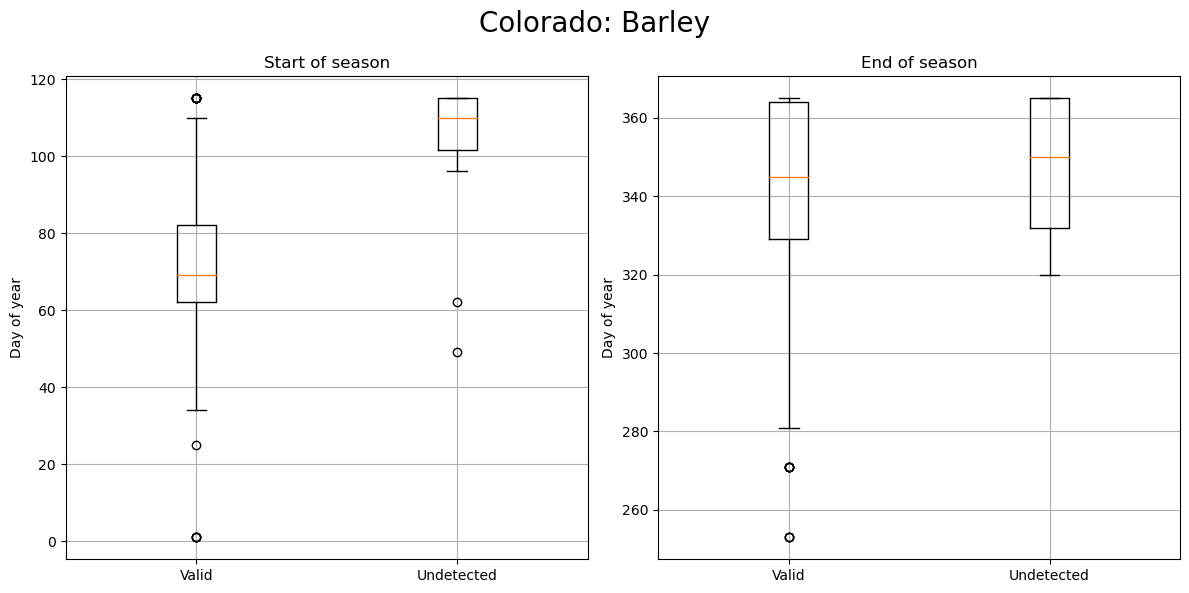

In [128]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].boxplot([valid_ssL,invalid_ssL])
ax[0].set_title('Start of season')
ax[0].set_ylabel('Day of year')
ax[0].set_xticklabels(['Valid','Undetected'])
ax[0].grid()

ax[1].boxplot([valid_esL,invalid_esL])
ax[1].set_title('End of season')
ax[1].set_ylabel('Day of year')
ax[1].set_xticklabels(['Valid','Undetected'])
ax[1].grid()

plt.suptitle(Case+': '+crop,fontsize=20)
plt.tight_layout()
plt.savefig('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Result/boxplot_season'+Case+crop+'.pdf')
plt.show()

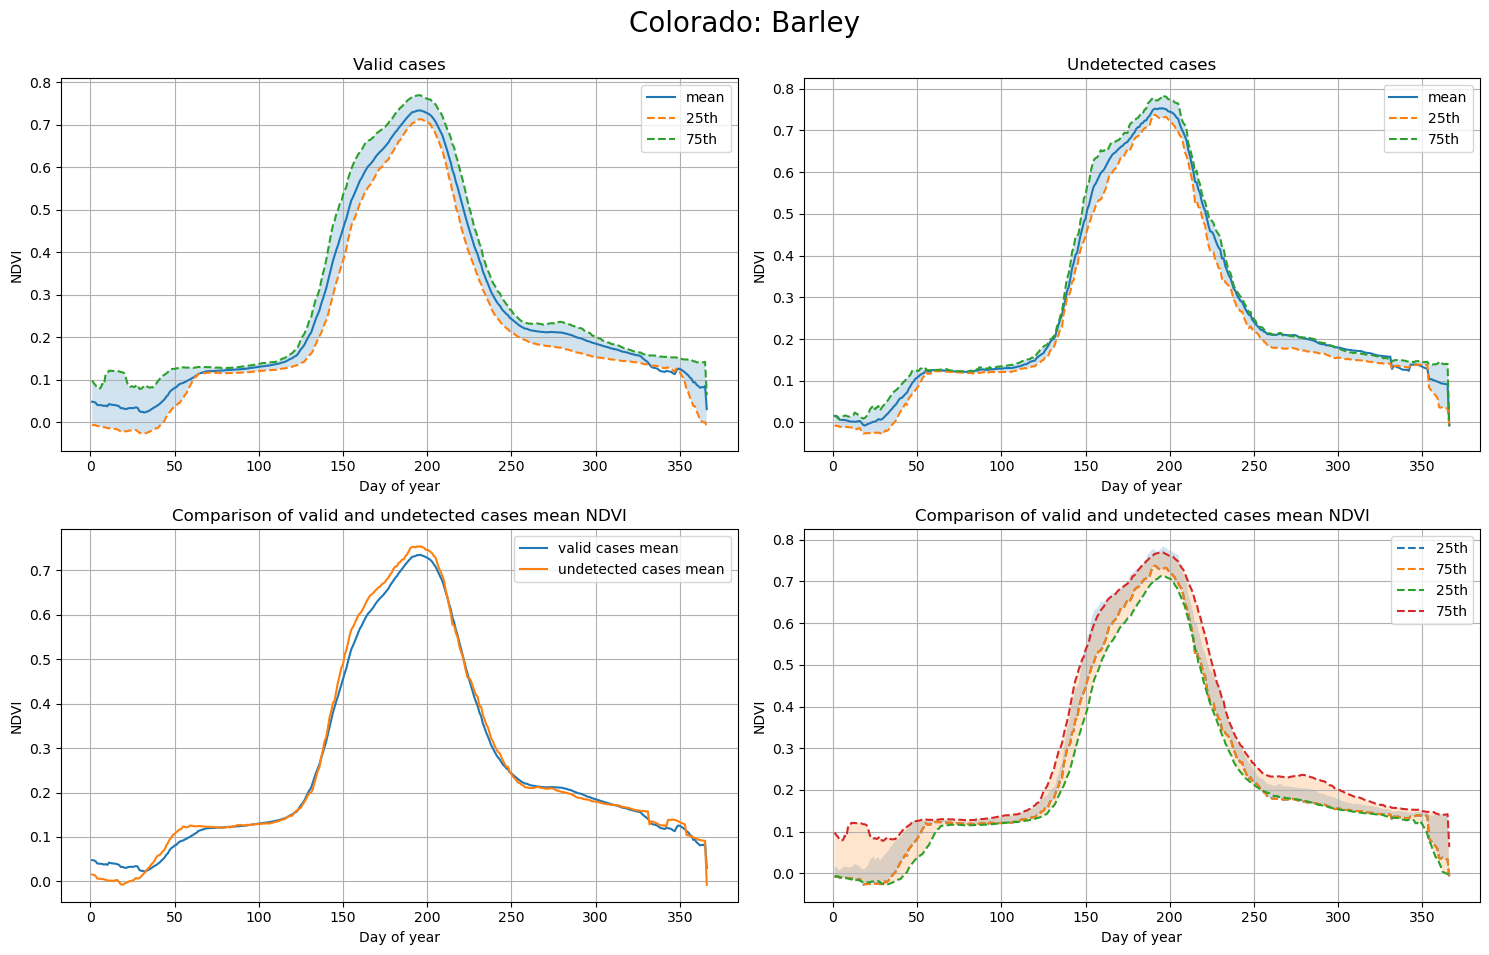

In [129]:
fig, ax=plt.subplots(2,2,figsize=(15,10))
ax[0,0].plot(valid_ts_df_doy.mean()['mean'],label='mean')
ax[0,0].plot(valid_ts_df_doy.quantile(0.25)['mean'],'--',label='25th')
ax[0,0].plot(valid_ts_df_doy.quantile(0.75)['mean'],'--',label='75th')
ax[0,0].fill_between(valid_ts_df_doy.mean().index, valid_ts_df_doy.quantile(0.25)['mean'], valid_ts_df_doy.quantile(0.75)['mean'], alpha=0.2)
ax[0,0].legend()
ax[0,0].set_title('Valid cases')
ax[0,0].grid()
ax[0,0].set_xlabel('Day of year')
ax[0,0].set_ylabel('NDVI')

ax[0,1].plot(invalid_ts_df_doy.mean()['mean'],label='mean')
ax[0,1].plot(invalid_ts_df_doy.quantile(0.25)['mean'],'--',label='25th')
ax[0,1].plot(invalid_ts_df_doy.quantile(0.75)['mean'],'--',label='75th')
ax[0,1].fill_between(invalid_ts_df_doy.mean().index, invalid_ts_df_doy.quantile(0.25)['mean'], invalid_ts_df_doy.quantile(0.75)['mean'], alpha=0.2)
ax[0,1].legend()
ax[0,1].set_title('Undetected cases')
ax[0,1].grid()
ax[0,1].set_xlabel('Day of year')
ax[0,1].set_ylabel('NDVI')

ax[1,0].plot(valid_ts_df_doy.mean()['mean'],label='valid cases mean')
ax[1,0].plot(invalid_ts_df_doy.mean()['mean'],label='undetected cases mean')
ax[1,0].legend()
ax[1,0].set_title('Comparison of valid and undetected cases mean NDVI')
ax[1,0].grid()
ax[1,0].set_xlabel('Day of year')
ax[1,0].set_ylabel('NDVI')

ax[1,1].plot(invalid_ts_df_doy.quantile(0.25)['mean'],'--',label='25th')
ax[1,1].plot(invalid_ts_df_doy.quantile(0.25)['mean'],'--',label='75th')
ax[1,1].fill_between(invalid_ts_df_doy.mean().index, invalid_ts_df_doy.quantile(0.25)['mean'], invalid_ts_df_doy.quantile(0.75)['mean'], alpha=0.2)
ax[1,1].plot(valid_ts_df_doy.quantile(0.25)['mean'],'--',label='25th')
ax[1,1].plot(valid_ts_df_doy.quantile(0.75)['mean'],'--',label='75th')
ax[1,1].fill_between(valid_ts_df_doy.mean().index, valid_ts_df_doy.quantile(0.25)['mean'], valid_ts_df_doy.quantile(0.75)['mean'], alpha=0.2)
ax[1,1].legend()
ax[1,1].set_title('Comparison of valid and undetected cases mean NDVI')
ax[1,1].grid()
ax[1,1].set_xlabel('Day of year')
ax[1,1].set_ylabel('NDVI')

plt.suptitle(Case+': '+crop,fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.savefig('C:/Users/Vito/Documents/Seed_to_harvest_process_monitoring/Result/NDVIts_compare'+Case+crop+'.pdf')
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1ea6f8de050>,
 'caps': [<matplotlib.lines.Line2D at 0x1ea6f8dd350>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ea83126c90>,
 'medians': [<matplotlib.lines.Line2D at 0x1ea6f8c8350>,
 'fliers': [<matplotlib.lines.Line2D at 0x1ea6e387d10>,
 'means': []}

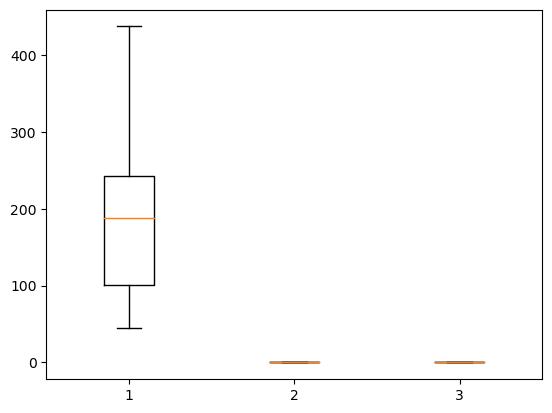

In [131]:
plt.boxplot(nan_counts)

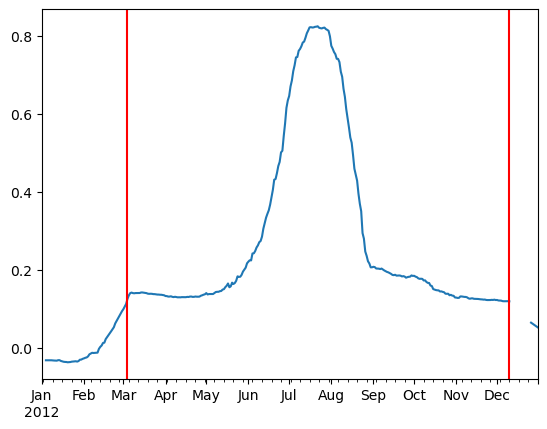

In [107]:
sid=53
yt=2012

ts=pd.read_hdf(sites_pth+f'/Site{sid:03}_NBARint.h5')
ts.drop('std', axis=1, inplace=True)
ts['DayOfYear'] = ts.index.dayofyear
season=pd.read_hdf(season_pth+f'/Site{sid:03}_season_day.h5')
start_season = season.loc[int(yt)]['start_season']
end_season = season.loc[int(yt)]['end_season']
ts['mean'][f'{yt}'].plot()
plt.axvline(start_season, color='r')
plt.axvline(end_season, color='r')

In [ ]:
ts.drop('std', axis=1, inplace=True)
ts['DayOfYear'] = ts.index.dayofyear
ts

In [ ]:
#check time series integrity?if there is a lot of missing data
#check shape?
#check relationship with crop?